In [1]:
using Distributions, Random, Plots, StatsBase, JLD2, Plots.PlotMeasures, StatsBase
path = "C:\\Users\\lucy_\\bats\\radiotrack"
include(string(path,"\\src\\StochasticSimulations.jl"))

┌ Info: Recompiling stale cache file C:\Users\lucy_\.julia\compiled\v1.1\Distributions\xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\lucy_\.julia\compiled\v1.1\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\lucy_\.julia\compiled\v1.1\JLD2\O1EyT.ji for JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1184


Main.StochasticSimulations

In [2]:
function diffusion_step(args,x,y)
    """
    Takes position x,y and returns a new position after a diffusion step
    with diffusion coefficient D and timestep dt
    """
    return x .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"]), y .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"])
end

function diffusion_simulation(args)
    """
    Stochastic diffusion simulation with discrete time and arguments
    args = (D=diffusion coefficient,N=number of particles,T=time of simulation,dt=timestep)
    returns positions in the trajectory.
    """
    t = args.dt:args.dt:args.T
    x = zeros(Float64,args.N,length(t))
    y = zeros(Float64,args.N,length(t))
    for (j,ts) in enumerate(t[1:end-1])
        x[:,j+1] = x[:,j] .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N)
        y[:,j+1] = y[:,j] .+ rand(Normal(0,sqrt(2*args.D*args.dt)),args.N)
    end
    return (x=x,y=y)
end


diffusion_simulation (generic function with 1 method)

In [3]:
N = 200
D = 65
T = 3600
dt = 10
args = (D=D,N=N,T=T,dt=dt)

simxy = args |> diffusion_simulation 
simmsd = simxy|> StochasticSimulations.square_distance

(MSD = [0.0 2470.97 … 9.58552e5 9.60519e5], std_error = [0.0, 167.486, 308.08, 452.023, 623.086, 743.203, 962.021, 1095.47, 1271.89, 1508.57  …  65947.7, 64564.8, 64105.2, 64604.4, 64484.8, 64737.5, 65461.2, 65762.2, 65186.6, 65435.6])

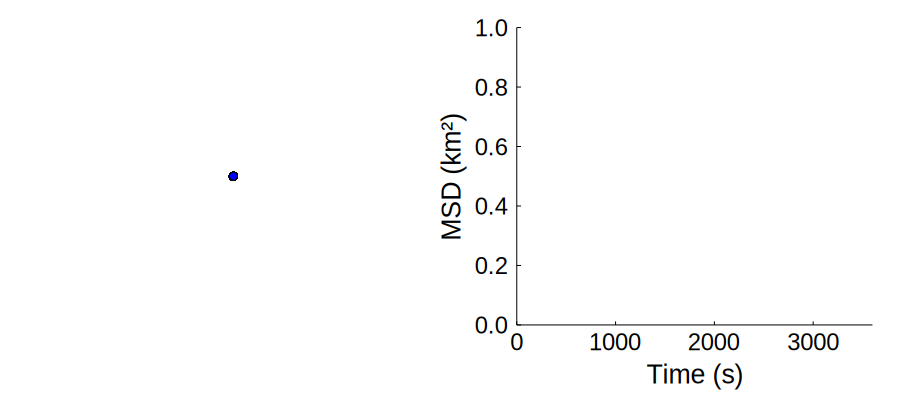

In [4]:
plt1 = scatter(simxy.x[:,1]',simxy.y[:,1]',
        label="", color=:blue, grid=false, showaxis=false, 
        xlim=(-2000,2000),ylim=(-2000,2000)
    )
    plt2 = plot(dt:dt:dt,simmsd.MSD[1:1]./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,T), ylim=(0,1), guidefontsize=18, tickfontsize=16,
        xlabel="Time (s)", ylabel="MSD (km²)", margin=5mm
    )
plot(plt1,plt2,size=(900,400),layout=(1,2))
#savefig("diffusion_start.png")

┌ Info: Saved animation to 
│   fn = C:\Users\lucy_\bats\radiotrack\jupyter\tmp.gif
└ @ Plots C:\Users\lucy_\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\lucy_\\bats\\radiotrack\\jupyter\\tmp.gif")
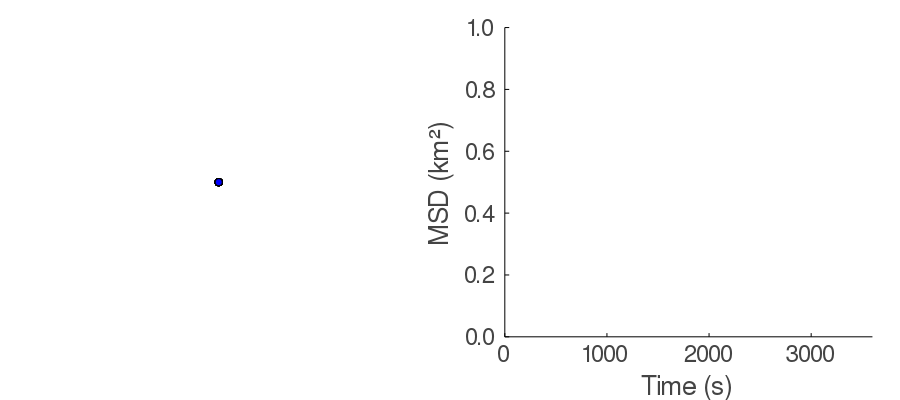

In [5]:
@gif for (i,time) in enumerate(dt:dt:2dt)
    plt1 = scatter(simxy.x[:,i]',simxy.y[:,i]',
        label="", color=:blue, grid=false, showaxis=false, left_margin=-5mm,
        xlim=(-2000,2000),ylim=(-2000,2000)
    )
    plt2 = plot(dt:dt:time,simmsd.MSD[1:i]./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,T), ylim=(0,1), guidefontsize=18, tickfontsize=16,
        xlabel="Time (s)", ylabel="MSD (km²)", margin=5mm
    )
    plot(plt1,plt2,size=(900,400),layout=(1,2))
end

In [7]:
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 
msd_rt = meansd;
sem_rt = semsd;
std_rt = stdsd;

In [3]:
function drift_step(args,x,y) 
    r = sqrt(x^2+y^2)
    if r > args["r_threshold"] 
        xdir = x/sqrt(x^2+y^2)
        ydir = y/sqrt(x^2+y^2)
        return x - xdir*args["chi"]*args["dt"]*(r^args["r_exp"]),y - ydir*args["chi"]*args["dt"]*(r^args["r_exp"]) 
    else
        return 0,0
    end
end

function r2_test(x1,y1,x_model,y_model)
    sstot = 0 
    ssres = 0
    for (i,xi) in enumerate(x1)
        sstot += (y1[i]-mean(y1))^2
        ssres +=  (y_model[findfirst(x->x==xi, x_model)]-y1[i])^2
    end 
    return 1 - ssres/sstot
end


function leapfrog_simulation(args)
    t = args["dt"]:args["dt"]:args["T"]
    x = zeros(Float64,args["N"],length(t))
    y = zeros(Float64,args["N"],length(t))
    for (j,ts) in enumerate(t[1:end-1]) 
        idx = argmax(x[:,j].^2 + y[:,j].^2)
        if ts < args["start_time"]
            x[:,j+1] = x[:,j]
            y[:,j+1] = y[:,j]
        elseif ts < args["tD"]
            x[:,j+1] = x[:,j] .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"])
            y[:,j+1] = y[:,j] .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"])
        else
            x[:,j+1] = x[:,j] .+ rand(Normal(0,sqrt(2*args["D2"]*args["dt"])),args["N"])
            y[:,j+1] = y[:,j] .+ rand(Normal(0,sqrt(2*args["D2"]*args["dt"])),args["N"])
            x[idx,j+1],y[idx,j+1] = drift_step(args,x[idx,j+1],y[idx,j+1])
        end
    end
    return (x=x,y=y)
end

function convection_step(x,y,args)
    r = sqrt(x^2+y^2)
    if r > args["r_threshold"] 
        xdir = x/sqrt(x^2+y^2)
        ydir = y/sqrt(x^2+y^2)
        return x- xdir*args["chi"]*args["dt"]*(r^args["r_exp"]), y- ydir*args["chi"]*args["dt"]*(r^args["r_exp"])
    else
        return 0,0
    end
end

function convection_diffusion_simulation(args)
    t = args["dt"]:args["dt"]:args["T"]
    x = zeros(Float64,args["N"],length(t))
    y = zeros(Float64,args["N"],length(t))
    for (j,ts) in enumerate(t[1:end-1]) 
        idx = argmax(x[:,j].^2 + y[:,j].^2)
        if ts < args["start_time"]
            x[:,j+1] = x[:,j]
            y[:,j+1] = y[:,j]
        elseif ts < args["tD"]
            x[:,j+1] = x[:,j] .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"])
            y[:,j+1] = y[:,j] .+ rand(Normal(0,sqrt(2*args["D"]*args["dt"])),args["N"])
        else
            x[:,j+1] = x[:,j] .+ rand(Normal(0,sqrt(2*args["D2"]*args["dt"])),args["N"])
            y[:,j+1] = y[:,j] .+ rand(Normal(0,sqrt(2*args["D2"]*args["dt"])),args["N"])
            for i = 1:args["N"]
                x[i,j+1],y[i,j+1] = convection_step(x[i,j+1],y[i,j+1],args)
            end
        end
    end
    return (x=x,y=y)
end

convection_diffusion_simulation (generic function with 1 method)

In [8]:
args = Dict("D"=>65,
        "D2"=>20.0,
        "chi"=>0.1,
        "dt"=>10,
        "T"=>3600*8,
        "N"=>100,
        "tD"=>4350,
        "start_time"=>280,
        "r_threshold"=>100,
        "r_exp"=>0 )

simxy = args |> convection_diffusion_simulation 
simmsd = simxy|> StochasticSimulations.square_distance

(MSD = [0.0 2714.97 … 1.03384e5 1.05403e5], std_error = [0.0, 277.096, 573.006, 832.192, 1009.66, 1190.67, 1506.91, 1738.22, 1996.82, 2244.87  …  31683.3, 31654.6, 31387.0, 30651.3, 30310.7, 30734.5, 30961.7, 30750.9, 30195.2, 30884.7])

In [9]:
plt1 = scatter(simxy.x[:,1]',simxy.y[:,1]',
        label="", color=:blue, grid=false, showaxis=false, 
        xlim=(-2000,2000),ylim=(-2000,2000)
    )
    plt2 = plot(dt:dt:dt,simmsd.MSD[1:1]./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,args["T"]./3600), ylim=(0,1.5), guidefontsize=18, tickfontsize=16,
        xlabel="Time from sunset (hours)", ylabel="MSD (km²)", margin=5mm
    )
plot(plt1,plt2,size=(900,400),layout=(1,2))
savefig("diffusion_convection_start.png")

In [21]:
@gif for (i,time) in enumerate(dt:5dt:args["T"])
    plt1 = scatter(simxy.x[:,i*5]',simxy.y[:,i*5]',
        label="", color=:blue, grid=false, showaxis=false, left_margin=-5mm,
        xlim=(-2000,2000),ylim=(-2000,2000)
    )
    plt2 = plot((dt:dt:time)./3600,simmsd.MSD[1:i*5]./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,args["T"]./3600), ylim=(0,1.5), guidefontsize=18, tickfontsize=16,
        xlabel="Time from sunset (hours)", ylabel="MSD (km²)", margin=5mm
    )
    plot(plt1,plt2,size=(900,400),layout=(1,2))
end

BoundsError: BoundsError: attempt to access 6-element Array{Float64,1} at index [1:10]

306.464781 seconds (1.84 G allocations: 379.637 GiB, 7.90% gc time)


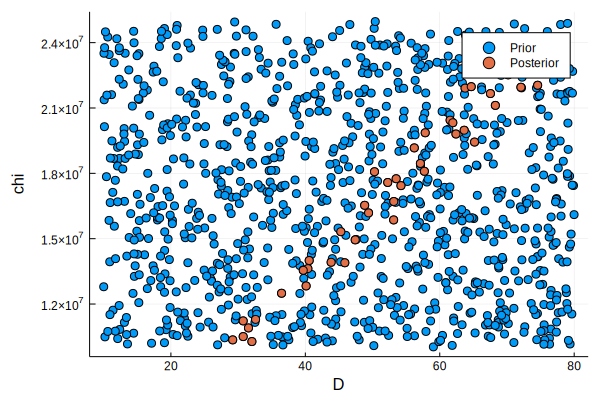

In [81]:
args = Dict("D"=>65,
        "D2"=>20.0,
        "chi"=>2.5e7,
        "dt"=>10,
        "T"=>3600*8,
        "N"=>100,
        "tD"=>4350,
        "start_time"=>280,
        "r_threshold"=>100,
        "r_exp"=>-2 )

sample_size = 1000
r2s = Array{Float64}(undef,sample_size)

chi_dist = Uniform(1e7, 2.5e7)
D1_dist = Uniform(60.0,70.0)
D2_dist = Uniform(10.0,80.0)
chis = rand(chi_dist, sample_size) 
Ds = rand(D1_dist, sample_size)
D2s = rand(D2_dist, sample_size)

@time for i = 1:sample_size
    args["D"] = Ds[i]
    args["D2"] = D2s[i]
    args["chi"] = chis[i]
    leapfrogsim = Array{Float64}(undef,2880,10)
    for i = 1:10
        leapfrogsim[:,i] = (args |> leapfrog_simulation |> StochasticSimulations.square_distance).MSD
    end
    medians = median(leapfrogsim,dims=2)
    r2s[i] = r2_test(t_rt,msd_rt,args["dt"]:args["dt"]:args["T"],medians)
end
idx = sortperm(r2s);

scatter(D2s,chis, xlabel="D",ylabel="chi",label="Prior")
scatter!(D2s[idx[end-div(sample_size,25):end]],chis[idx[end-div(sample_size,25):end]], label="Posterior")

1624.788375 seconds (8.93 G allocations: 1.849 TiB, 8.00% gc time)


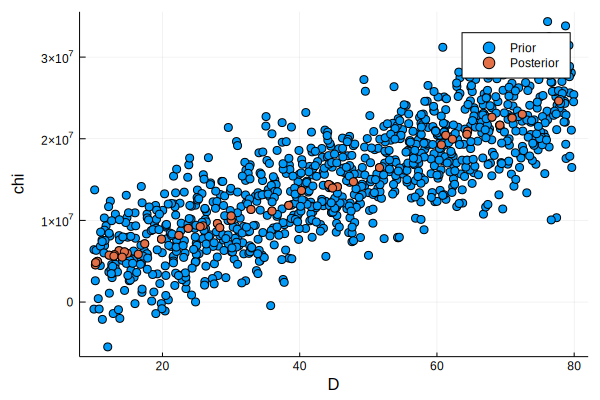

In [107]:
using LsqFit
@. model(D, p) = p[1]*D+p[2]
xdata = D2s[idx[end-div(sample_size,50):end]]
ydata = chis[idx[end-div(sample_size,50):end]]
p0 = [10.0^5, 10.0^5]
fit_ = curve_fit(model, xdata, ydata, p0)
chi_line = coef(fit_)
coef(fit_), confidence_interval(fit_, 0.1)


Ds = rand(D1_dist, sample_size)
D2s = rand(D2_dist, sample_size)
chis = chi_line[1].*D2s .+chi_line[2] .+ rand(Normal(0,4e6), sample_size)

@time for i = 1:sample_size
    args["D"] = Ds[i]
    args["D2"] = D2s[i]
    args["chi"] = chis[i]
    leapfrogsim = Array{Float64}(undef,2880,50)
    for i = 1:50
        leapfrogsim[:,i] = (args |> leapfrog_simulation |> StochasticSimulations.square_distance).MSD
    end
    medians = median(leapfrogsim,dims=2)
    r2s[i] = r2_test(t_rt,msd_rt,args["dt"]:args["dt"]:args["T"],medians)
end
idx = sortperm(r2s);

scatter(D2s,chis, xlabel="D",ylabel="chi",label="Prior")
scatter!(D2s[idx[end-div(sample_size,25):end]],chis[idx[end-div(sample_size,25):end]], label="Posterior")

In [108]:
print("r2 = ", r2s[idx[end]], ", D1 = ", Ds[idx[end]], ", D2 = ", D2s[idx[end]], ", chi = ", chis[idx[end]])

r2 = 0.9137778736111849, D1 = 62.87138353434305, D2 = 14.125822312518695, chi = 5.505540131707218e6

In [10]:
args = Dict("D"=> 62.871,
        "D2"=> 14.126,
        "chi"=> 5.5055e6,
        "dt"=> 10,
        "T"=> 3600*8,
        "N"=> 100,
        "tD"=> 4350,
        "start_time"=> 280,
        "r_threshold"=> 100,
        "r_exp"=> -2 )

msds = Array{Float64}(undef,2880,1000)
maxds = Array{Float64}(undef,2880,1000)
for i = 1:1000
    simxy = args |> leapfrog_simulation 
    msds[:,i] = (simxy |> StochasticSimulations.square_distance).MSD
    maxds[:,i] = (simxy |> max_distance)
end

#simxy = args |> leapfrog_simulation 
#simmsd = simxy|> StochasticSimulations.square_distance
#simmaxsd = simxy|> StochasticSimulations.max_distance

meanmsds = median(msds,dims=2)
meanmaxds = median(maxds,dims=2)
#simmaxsd = simxy|> StochasticSimulations.max_distance
#sem = sqrt.(StatsBase.var(drift_sim,dims=2)./1000);

print(r2_test(t_rt,msd_rt,args["dt"]:args["dt"]:args["T"],meanmsds))

0.92620703350848

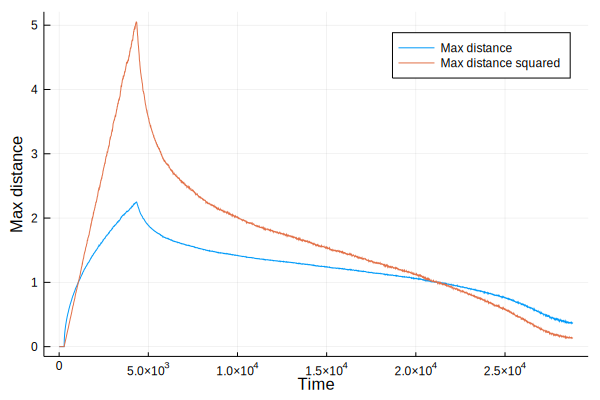

In [20]:
#plot(args["dt"]:args["dt"]:args["T"], sqrt.(meanmaxds./1e6),xlabel="Time", ylabel="Max distance", label="Max distance")
plot!(args["dt"]:args["dt"]:args["T"], meanmaxds./1e6,xlabel="Time", ylabel="Max distance", label="Max distance squared")
#plot!(meanmsds./1e6)

In [112]:

plot(xlabel="Time from sunset (hours)", ylabel="MSD (km²)", 
    markersize=8, color=:red,
    size=(800,500), grid=false,
    ylims=(0,1.6),
    tickfontsize=16, guidefontsize=16, legendfontsize=12, margin=10mm)
scatter!(t_rt./3600., msd_rt./10^6, label="Data",
    ribbon=sem_rt./10^6, fill=:orange, 
    markersize=8, color=:red)
plot!((args["dt"]:args["dt"]:args["T"])./3600,means./10^6,
    ribbon=sem./10^6,
    color=:blue, label="Stochastic model")
savefig("./leapfrog_fit.png")

┌ Info: Saved animation to 
│   fn = C:\Users\lucy_\bats\radiotrack\jupyter\tmp.gif
└ @ Plots C:\Users\lucy_\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\lucy_\\bats\\radiotrack\\jupyter\\tmp.gif")
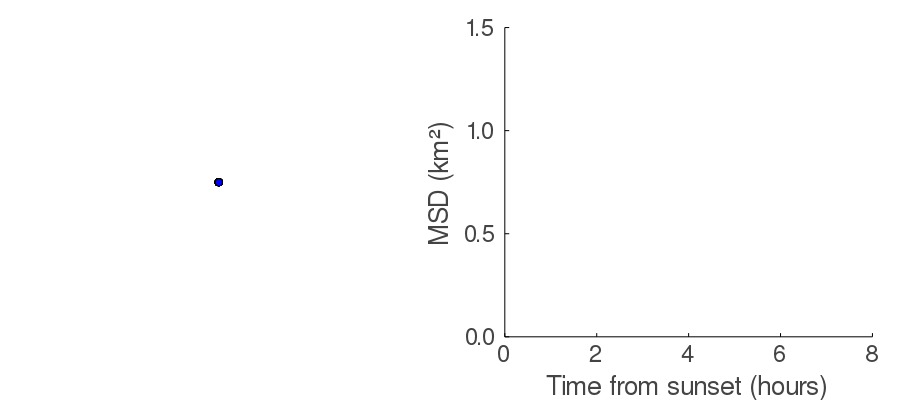

In [125]:
simxy = args |> leapfrog_simulation 
simmsd = simxy|> StochasticSimulations.square_distance

@gif for (i,time) in enumerate(5dt:5dt:args["T"])
    R = sqrt.(simxy.x[:,5i].^2 .+ simxy.y[:,5i].^2)
    plt1 = scatter(simxy.x[:,5i]',simxy.y[:,5i]',
        label="", color=:blue, grid=false, showaxis=false, left_margin=-5mm,
        xlim=(-2000,2000),ylim=(-2000,2000)
    )
    plt2 = plot((dt:dt:time)./3600,simmsd.MSD[1:5i]./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,args["T"]./3600), ylim=(0,1.5), guidefontsize=18, tickfontsize=16,
        xlabel="Time from sunset (hours)", ylabel="MSD (km²)", margin=5mm
    )
    plot(plt1,plt2,size=(900,400),layout=(1,2))
end

In [9]:
function max_distance(xy)
    """
    Calculates the max distance from 0 for trajectory xy.
    """
    SD = xy.x.^2 .+ xy.y.^2;
    return maximum(SD,dims=1)
end

max_distance (generic function with 1 method)

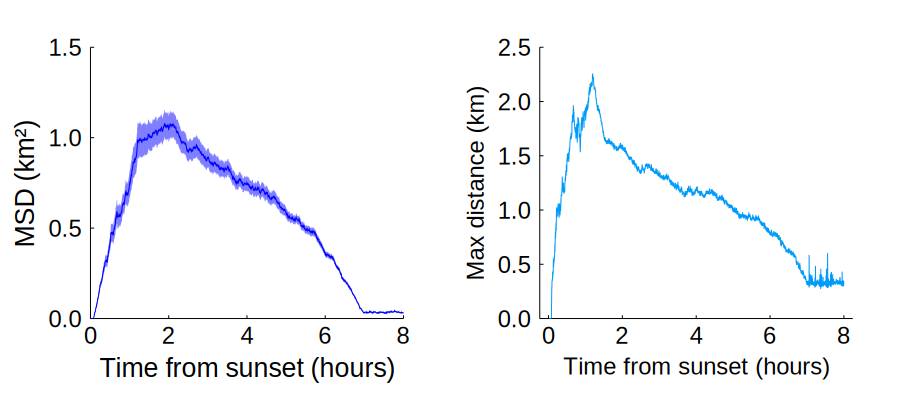

In [34]:
args = Dict("D"=> 62.8,
        "D2"=> 14.1,
        "chi"=> 5.5e6,
        "dt"=> 10,
        "T"=> 3600*8,
        "N"=> 100,
        "tD"=> 4350,
        "start_time"=> 280,
        "r_threshold"=> 100,
        "r_exp"=> -2 )

simxy = args |> leapfrog_simulation 
simmsd = simxy|> StochasticSimulations.square_distance
simmaxsd = simxy|> StochasticSimulations.max_distance




plt2 = plot(xlabel="Time from sunset (hours)", ylabel="Max distance (km)", 
    markersize=8, color=:red,
    size=(800,500), grid=false,
    ylims=(0,2.5),
    tickfontsize=16, guidefontsize=16, legendfontsize=12, margin=10mm)
plot!((args["dt"]:args["dt"]:args["T"])./3600,R./1000,label="")

plt1 = plot((args["dt"]:args["dt"]:args["T"])./3600,simmsd.MSD'./1e6,
        ribbon=simmsd.std_error./1e6,grid=false, label="", color=:blue,
        xlim=(0,args["T"]./3600), ylim=(0,1.5), guidefontsize=18, tickfontsize=16,
        xlabel="Time from sunset (hours)", ylabel="MSD (km²)", margin=5mm)

plot(plt1,plt2,size=(900,400),layout=(1,2))

In [6]:
drift_sim = Array{Float64}(undef,2880,1000)
for i = 1:1000
    x,y = args |> leapfrog_simulation #|> StochasticSimulations.square_distance).MSD
end

means = median(drift_sim,dims=2)
sem = sqrt.(StatsBase.var(drift_sim,dims=2)./1000);

#print(r2_test(t_rt,msd_rt,args["dt"]:args["dt"]:args["T"],means))

UndefVarError: UndefVarError: t_rt not defined

In [8]:

means = median(drift_sim,dims=2)
sem = sqrt.(StatsBase.var(drift_sim,dims=2)./1000);

print(r2_test(t_rt,msd_rt,args["dt"]:args["dt"]:args["T"],means))

-5.073474556120905

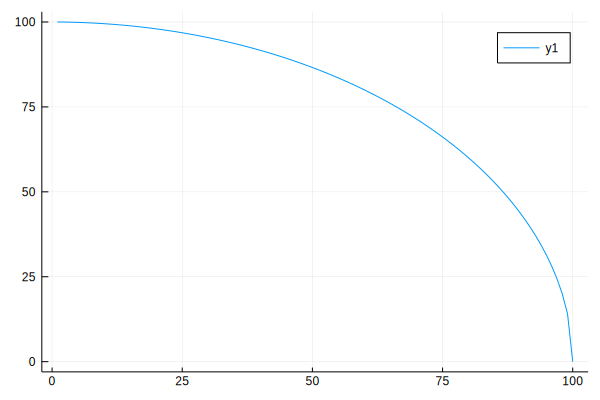

In [25]:
x = 1:100
plot(x,sqrt.(10000 .-x.^2))